In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from itertools import islice
from scipy.stats import skew, norm, boxcox_normmax
from scipy.special import boxcox1p
from statsmodels.stats.proportion import proportions_ztest
import warnings
warnings.filterwarnings(action='ignore')

In [38]:
#load data from EDA
df = pd.read_csv("../data/ABtwoCampaignEngView.csv")
df_control = pd.read_csv("../data/control_df_two.csv")
df_exposed = pd.read_csv("../data/exposed_df_two.csv")


# Hypothesis testing - p-value based algorithm
* Null hypothesis: the change in the 'smartAD' design which is newly made for the exposed group would result in no change in the conversion rate.
* Alternative hypothesis: the change in the advertisement design would have a positive(improvement) or negative(degradation) effect in the conversion rate.
* level of significance = 0.05

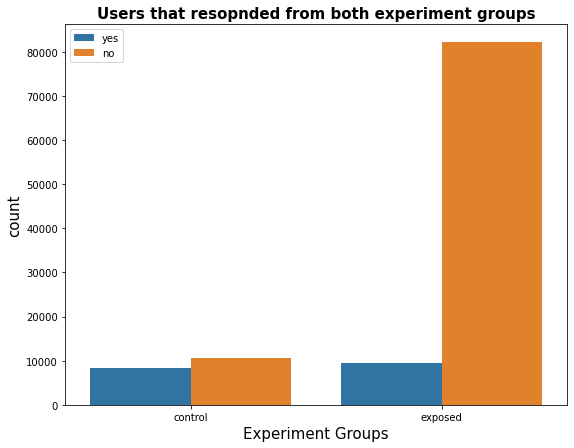

In [39]:
#extract users that didnt respond and users that did, for both experiment groups
drop_df = df.query('yes==0 and no==0')
df = df.drop(drop_df.index)

plt.figure(figsize=(9,7))
ax=sns.countplot(x='experiment', hue='yes', data= df)

ax.set_xlabel('Experiment Groups', fontsize=15)
ax.set_ylabel('count', fontsize=15)
ax.set_title('Users that resopnded from both experiment groups',fontsize=15,fontweight='bold')
plt.legend(['yes','no'])

### In the previous data we observed a very small number of auctions. But in this dataframe, We will be working  with more than 100,000 entries. 
### So unlike the balanced distributions of responses in the previous data, Here, The most significant answer is a no from the exposed group.

In [40]:
##copy the dataframe
res = df.copy(deep='true')

In [41]:
# getting users who responded
res = res[res['yes'] == 1].append(res[res['no']==1])
res.head(10)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
80,eb941471-f485-4516-b4d3-648e7838d53a,control,<built-in method date of Timestamp object at 0...,15,Apple,101,15,1.0,0.0
84,622af8e2-7bcf-4681-a921-442e1f8378f1,control,<built-in method date of Timestamp object at 0...,6,Apple,101,5,1.0,0.0
103,56a03982-6278-4083-9554-3a069dbc22c8,control,<built-in method date of Timestamp object at 0...,20,Samsung,162,6,1.0,0.0
209,2711e2f3-a624-4243-800e-693a888bc394,control,<built-in method date of Timestamp object at 0...,3,Samsung,162,6,1.0,0.0
255,822e43cb-47a4-4101-90bb-02e7e1c2f576,control,<built-in method date of Timestamp object at 0...,15,Apple,101,7,1.0,0.0
283,e5ca3951-25c6-4a70-ae24-67bd86ef8ec1,control,<built-in method date of Timestamp object at 0...,6,Apple,101,6,1.0,0.0
292,1f05a027-639e-410f-9c33-77713cf266b0,control,<built-in method date of Timestamp object at 0...,1,Apple,101,6,1.0,0.0
324,b7701191-80f7-4a1e-8e0d-635c5e6101d4,control,<built-in method date of Timestamp object at 0...,9,Samsung,101,6,1.0,0.0
398,374889ca-37f6-4bd5-9bf2-f91dbade671b,control,<built-in method date of Timestamp object at 0...,16,Motorola,162,15,1.0,0.0
537,c5d48ba7-a735-4d70-94a8-bb7637b6e486,control,<built-in method date of Timestamp object at 0...,6,Apple,101,7,1.0,0.0


In [42]:
#find control and exposed groups
control_df = res[res['experiment'] == 'control']
exposed_df = res[res['experiment'] == 'exposed']

In [43]:
control_df.head(10)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
80,eb941471-f485-4516-b4d3-648e7838d53a,control,<built-in method date of Timestamp object at 0...,15,Apple,101,15,1.0,0.0
84,622af8e2-7bcf-4681-a921-442e1f8378f1,control,<built-in method date of Timestamp object at 0...,6,Apple,101,5,1.0,0.0
103,56a03982-6278-4083-9554-3a069dbc22c8,control,<built-in method date of Timestamp object at 0...,20,Samsung,162,6,1.0,0.0
209,2711e2f3-a624-4243-800e-693a888bc394,control,<built-in method date of Timestamp object at 0...,3,Samsung,162,6,1.0,0.0
255,822e43cb-47a4-4101-90bb-02e7e1c2f576,control,<built-in method date of Timestamp object at 0...,15,Apple,101,7,1.0,0.0
283,e5ca3951-25c6-4a70-ae24-67bd86ef8ec1,control,<built-in method date of Timestamp object at 0...,6,Apple,101,6,1.0,0.0
292,1f05a027-639e-410f-9c33-77713cf266b0,control,<built-in method date of Timestamp object at 0...,1,Apple,101,6,1.0,0.0
324,b7701191-80f7-4a1e-8e0d-635c5e6101d4,control,<built-in method date of Timestamp object at 0...,9,Samsung,101,6,1.0,0.0
398,374889ca-37f6-4bd5-9bf2-f91dbade671b,control,<built-in method date of Timestamp object at 0...,16,Motorola,162,15,1.0,0.0
537,c5d48ba7-a735-4d70-94a8-bb7637b6e486,control,<built-in method date of Timestamp object at 0...,6,Apple,101,7,1.0,0.0


In [44]:
exposed_df.head(10)

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
456356,143da30d-ebde-467f-8d66-acc80a4ff898,exposed,<built-in method date of Timestamp object at 0...,19,Samsung,101,15,1.0,0.0
456358,28304800-7650-4dae-84be-17e5b5c04868,exposed,<built-in method date of Timestamp object at 0...,4,Samsung,101,6,1.0,0.0
456364,f6d8f3f7-75b6-45a2-a277-793f3b387398,exposed,<built-in method date of Timestamp object at 0...,8,Apple,101,7,1.0,0.0
456365,dd0355b7-b1cd-4c87-bf70-2c2093dd61b2,exposed,<built-in method date of Timestamp object at 0...,0,Apple,163,7,1.0,0.0
456368,9728e114-5e94-4fb9-a193-44766e2abc55,exposed,<built-in method date of Timestamp object at 0...,14,Samsung,162,6,1.0,0.0
456372,fce5aa67-350e-44a5-8673-df73c7dd6ae7,exposed,<built-in method date of Timestamp object at 0...,6,Apple,101,7,1.0,0.0
456383,a1226e44-0a61-491a-89f4-cc891a96a3ed,exposed,<built-in method date of Timestamp object at 0...,13,Samsung,101,6,1.0,0.0
456404,d9e48996-a8b7-4252-9eb7-d127cbe1f7c2,exposed,<built-in method date of Timestamp object at 0...,23,Samsung,156,15,1.0,0.0
456406,99b6228b-d0bb-4fe8-b3a4-8fc13228e25e,exposed,<built-in method date of Timestamp object at 0...,14,Samsung,155,6,1.0,0.0
456413,21f53628-eda4-4e6e-ae52-7b95780ff7d2,exposed,<built-in method date of Timestamp object at 0...,18,Google,101,6,1.0,0.0


In [46]:
##count yes and no values per day
exposed_dfmake = (exposed_df.groupby('device_make').agg(yes=('yes','sum'), no=('no','sum')).reset_index())
control_dfmake = (control_df.groupby('device_make').agg(yes=('yes','sum'), no=('no','sum')).reset_index())

In [47]:
## extract out yes and no for both groups
exposed = exposed_dfmake[['yes','no']]
control = control_dfmake[['yes', 'no']]

In [51]:
# calculate engagements for both groups and append an engagement column
exposed['engagement'] = exposed['yes'] / (exposed['yes'] + exposed['no'])
control['engagement'] = control['yes'] / (control['yes'] + control['no'])

exposed.head()

,yes,no,engagement
0,8.0,7.0,0.533333
1,1.0,0.0,1.000000
2,7.0,0.0,1.000000
3,9.0,0.0,1.000000
4,2.0,0.0,1.000000


In [52]:
control.head()

,yes,no,engagement
0,9.0,5.0,0.642857
1,1.0,1.0,0.500000
2,18.0,159.0,0.101695
3,7562.0,7107.0,0.515509
4,2.0,13.0,0.133333


# Here it can be observed that, when aggregated per device_make, the following example engagements per phone company was recorded

In [53]:
import sys
sys.path.insert(0, '../scripts')
from VisualisationPlots import VisualiseDf

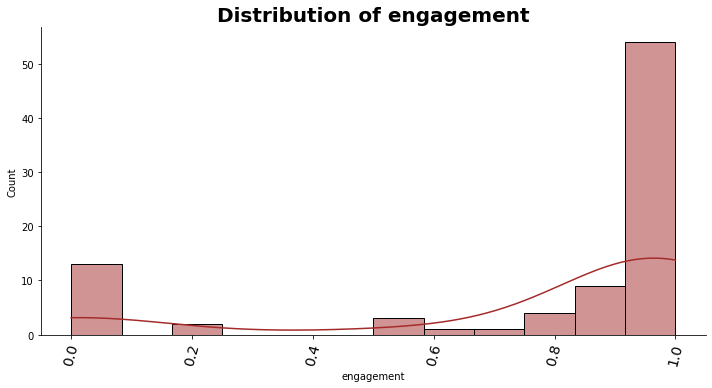

In [54]:
#exposed
VisualiseDf.plot_hist(exposed,'engagement','brown')

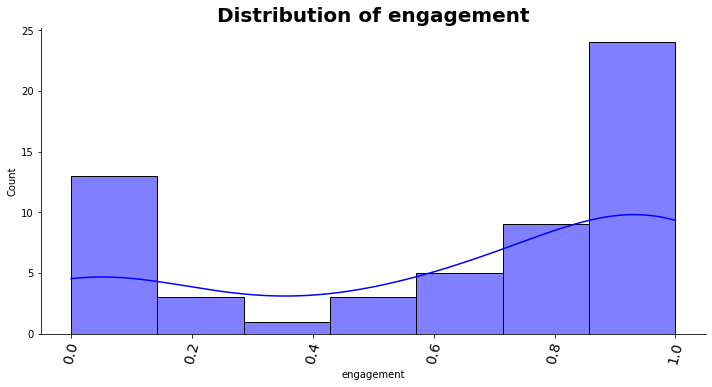

In [55]:
#control
VisualiseDf.plot_hist(control,'engagement','blue')

# Exposed group is more engaged, 
* unlike as observed in the previous dataset, Here the exposed group is more engaged

In [60]:
def find_pr(g1,g2):
    p1 = (g1['yes'].sum()) / float(g1['no'].sum() + g1['yes'].sum())
    p2 = (g2['yes'].sum()) / float(g2['no'].sum() + g2['yes'].sum())
    d = p2-p1
    print(p1,p2,d)
    
find_pr(control,exposed)

0.563045663791735 0.8959431008715951 0.3328974370798601


In [61]:
#Standard errors
def find_SE(g1, g2):
    
    p_overall = (g1['yes'].sum() + g2['yes'].sum() )/((g1['no'].sum() + g1['yes'].sum())+ (g2['no'].sum() + g2['yes'].sum()))
 
    SE1 = (p_overall * (1 - p_overall))/(g1['no'].sum() + g1['yes'].sum())
    
    SE2 = (p_overall * (1- p_overall))/(g2['no'].sum() + g2['yes'].sum())
    
    SE = np.sqrt(float(SE1) + float(SE2))
    
    print('SE:', SE)
find_SE(control, exposed)

SE: 0.00293582489433174


# Standard error is smaller as compared to that of the previous dataset

In [62]:
#t-value
import scipy.stats
def find_T(g1, g2):
    SE = 0.028319932727228023
    d = 0.18285619295484168
    alpha = 0.05
    tStatistic = (d-0) / SE
   
    dof = ((g1['no'].sum() + g1['yes'].sum()) + (g2['no'].sum() + g2['yes'].sum()) - 2.0)
  
    criticalValue = scipy.stats.t.ppf(1.0 - alpha, df = dof)
    
# Confidence Interval
    CI = [d - (criticalValue * SE), d + (criticalValue * SE)]  
    p_val = (1 - scipy.stats.t.cdf(abs(tStatistic), df = dof)) * 2.0
    print(tStatistic,'||', dof,'||', criticalValue,'||', p_val)
find_T(control, exposed)

6.4568018122103705 || 110568.0 || 1.6448674083528927 || 1.0737966071872052e-10


In [63]:
# conclusion on p value
success = np.array([exposed['yes'].sum(), control['yes'].sum()])
total_response = np.array([exposed['no'].sum() + exposed['yes'].sum(), control['no'].sum() + control['yes'].sum()])
# 
zTest_statistic, zTest_pval = proportions_ztest(success, total_response, value=0, alternative='two-sided')
# 
print(f't-vlaue is {round(zTest_statistic,4)}')
print(f'p-value is {round(zTest_pval,4)}')

t-vlaue is 113.3914
p-value is 0.0


# --------------------------------------------------------------------------------------------------------------
# To conclude, the p value calculated is less than the level of significance, $\alpha$ which is 0.05. But this was not the case for the previous data set in which we weren't able to drop the H0.

* This means we can reject the null hypothesis, and there is statistically significant difference between the dummy and 'new' adverts. 

# -------------------------------------------------------------------------------------------------------------